# Analysis of misclassified examples

This notebook serves as a visulization of misclassified examples in the pretrained model.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import cv2
import math
from glob import glob
import os
import sys
from keras.models import load_model
from vis.visualization import visualize_saliency
model = None

Using TensorFlow backend.


# Using saved model to directly predict on train set

## Load and preprocess training images

In [2]:
master = pd.read_csv("../input/train_labels.csv")
img_path = "../input/train/"

y = []
file_paths = []
for i in range(len(master)):
    file_paths.append( img_path + str(master.iloc[i, 0]) +'.jpg' ) # .ix same as .iloc
    y.append(master.iloc[i,1])
y = np.array(y)

### Aside: consider different downsampling schemes

From the raw view, the **area** interpolation gives the best output. On the other hand, research of another group from Stanford suggest **Lanczos** downsampling.

In [3]:
def read_img(img_path, interpolation):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (150, 150), interpolation = interpolation)
    return img

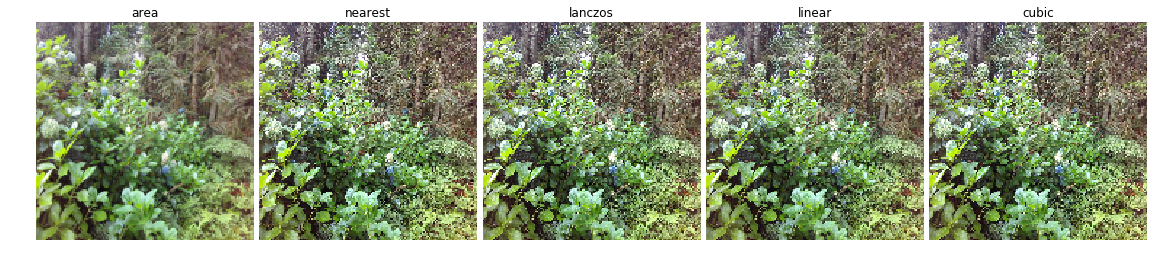

In [4]:
i = 10
img_area = read_img(file_paths[i], cv2.INTER_AREA)
img_near = read_img(file_paths[i], cv2.INTER_NEAREST)
img_lanc = read_img(file_paths[i], cv2.INTER_LANCZOS4)
img_lin = read_img(file_paths[i], cv2.INTER_LINEAR)
img_cub = read_img(file_paths[i], cv2.INTER_CUBIC)

fig, axes = plt.subplots(1,5, sharey=True, figsize=(20,4))
axes[0].imshow(img_area); axes[0].set_title('area'); axes[0].axis('off')
axes[1].imshow(img_near); axes[1].set_title('nearest'); axes[1].axis('off')
axes[2].imshow(img_lanc); axes[2].set_title('lanczos'); axes[2].axis('off')
axes[3].imshow(img_lin); axes[3].set_title('linear'); axes[3].axis('off')
axes[4].imshow(img_cub); axes[4].set_title('cubic'); axes[4].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)

### Preprocessing images pipeline

In [5]:
#image resize & centering & crop 

def centering_image(img):
    size = [256,256]
    
    img_size = img.shape[:2]
    
    # centering
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized

In [6]:
X = []
for i, file_path in enumerate(file_paths):
    sys.stdout.write("\r {0} from total {1} images".format(file_path, len(file_paths)))
    sys.stdout.flush()
    #read image
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    #resize
    if(img.shape[0] > img.shape[1]):
        tile_size = (int(img.shape[1]*256/img.shape[0]),256)
    else:
        tile_size = (256, int(img.shape[0]*256/img.shape[1]))
    img = cv2.resize(img, dsize=tile_size)

    #centering
    img = centering_image(img)

    #out put 224*224px 
    img = img[16:240, 16:240]

    X.append(img)

X = np.array(X)

 ../input/train/2295.jpg from total 2295 images

In [7]:
X = X.astype('float32')
X /= 255

## Load saved model `VGG16-transferlearning.model`

In [8]:
if not model:
    model = load_model('VGG16-transferlearning.model')

In [9]:
y_pred = model.predict(X)

## Compare label and predictions

### ROC curve

In [32]:
from sklearn.metrics import roc_curve, auc
def roc_plot(y_test, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.6f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

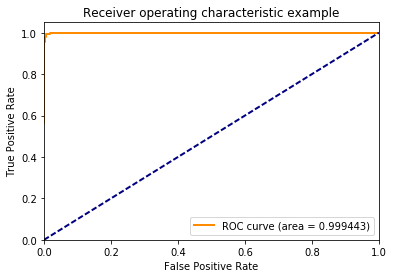

In [33]:
roc_plot(y, y_pred.reshape(-1))

### Threshold at 0.5

In [11]:
y_pred_cls = (y_pred > 0.5).astype('int')

In [12]:
df_pred1 = master.copy()
df_pred1['probability'] = y_pred
df_pred1['predictions'] = y_pred_cls
df_pred1['misclassified'] = (df_pred1.invasive == df_pred1.predictions).astype('int')

In [13]:
misclass_id1 = df_pred1[df_pred1.misclassified == 0]
print(misclass_id1.shape)
misclass_id1

(15, 5)


name  invasive  probability  predictions  misclassified
106    107         1     0.227027            0              0
230    231         1     0.180854            0              0
303    304         1     0.407863            0              0
312    313         1     0.257789            0              0
402    403         0     0.927957            1              0
498    499         1     0.410043            0              0
536    537         1     0.142789            0              0
651    652         0     0.992655            1              0
785    786         0     0.977202            1              0
831    832         0     0.705593            1              0
1419  1420         0     0.563792            1              0
1581  1582         0     0.905359            1              0
1597  1598         0     0.999946            1              0
1810  1811         0     0.674704            1              0
1954  1955         1     0.044751            0              0

## Visualization of misclassified images

### Group plot

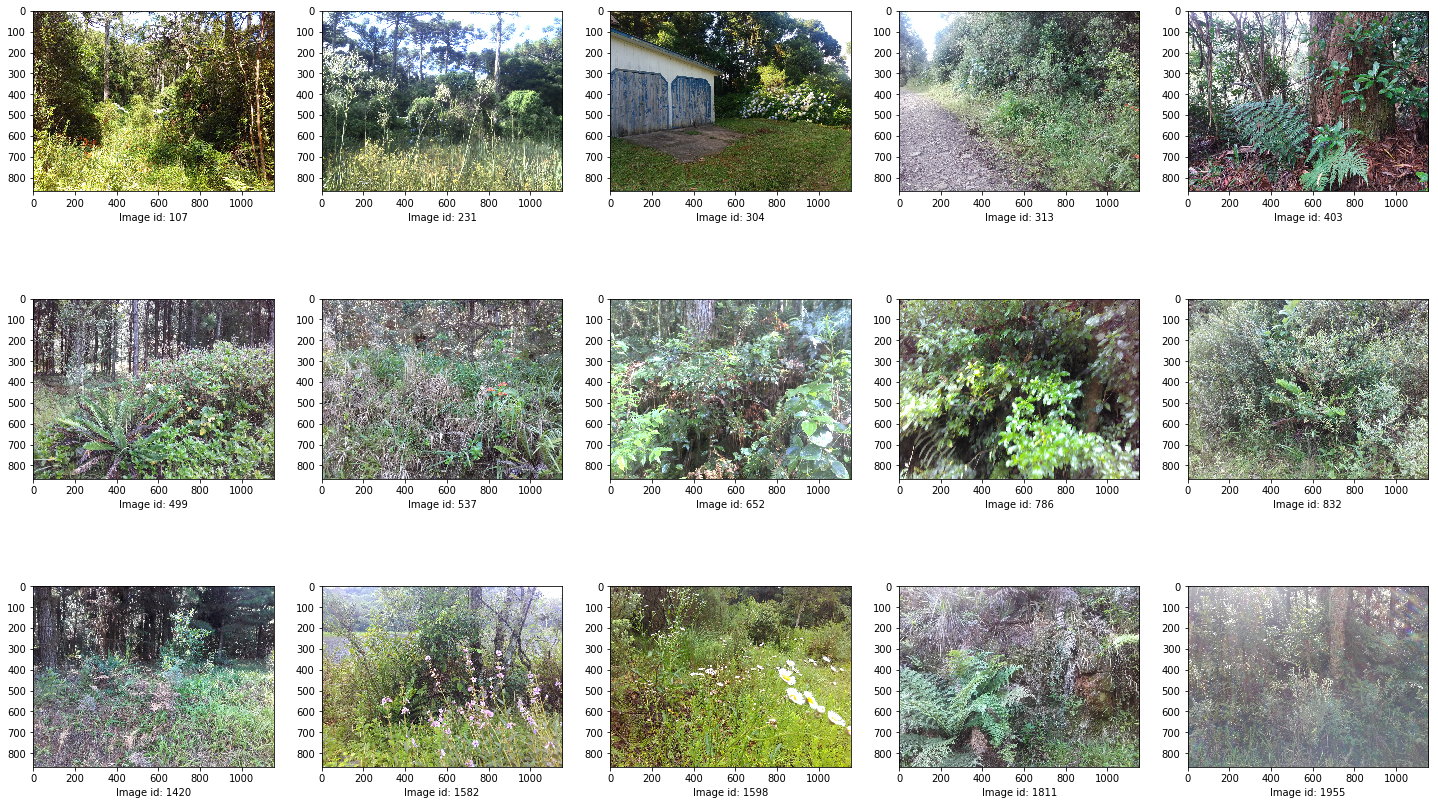

In [14]:
ids = misclass_id1.name
fig, axes = plt.subplots(3, 5, figsize=(25, 15))
for i, ax in enumerate(axes.flat):
    file_path = '../input/train/'+str(ids.iloc[i])+'.jpg'
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_xlabel('Image id: {}'.format(ids.iloc[i]))
#plt.tight_layout()
plt.show()

## Visualization of convnet -- Saliency map

In [8]:
if not model:
    model = load_model('VGG16-transferlearning.model')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [9]:
from vis.utils import utils
layer_idx = utils.find_layer_idx(model, 'dense_2')

In [10]:
def saliency_plot(i):
    # model prediction
    y_pred = model.predict(np.expand_dims(X[i-1], axis=0))
    print('predicted probability: {:.6f}'.format(float(y_pred)))
    # saliency map
    saliency_map = visualize_saliency(model, layer_idx, filter_indices=0, seed_input=X[i-1], 
                                      backprop_modifier='guided', grad_modifier='relu')

    fig, axes = plt.subplots(1, 2, figsize=(9.5,5))
    axes[0].imshow(X[i-1]) 
    axes[0].set_title('Preprocessed Image {}'.format(i)); axes[0].axis('off')
    axes[1].imshow(np.amax(np.abs(saliency_map), axis=2), cmap=plt.cm.gray, interpolation='gaussian')
    axes[1].set_title('Saliency Map'); axes[1].axis('off')
    plt.show()

predicted probability: 1.000000


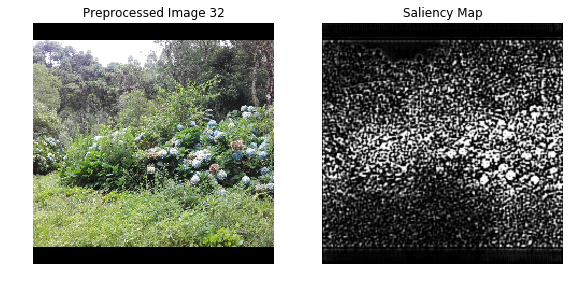

In [23]:
saliency_plot(i=32)

In [12]:
from vis.visualization import overlay
def saliency_overlay(i):
    # model prediction
    y_pred = model.predict(np.expand_dims(X[i-1], axis=0))
    print('predicted probability: {:.6f}'.format(float(y_pred)))
    # saliency map
    saliency_map = visualize_saliency(model, layer_idx, filter_indices=0, seed_input=X[i-1], 
                                      backprop_modifier='guided', grad_modifier='relu')
    fig, axes = plt.subplots(1, 3, figsize=(15,5))    
    axes[0].imshow(overlay(X[i-1], saliency_map)) 
    axes[0].set_title('Overlay Images {}'.format(i)); axes[0].axis('off')
    axes[1].imshow(saliency_map) 
    axes[1].set_title('Color saliency map {}'.format(i)); axes[1].axis('off')
    axes[2].imshow(X[i-1]) 
    axes[2].set_title('Preprocessed Image {}'.format(i)); axes[2].axis('off')
    plt.show()

Example detecting true positive: **Hydrangea with only leaves**

predicted probability: 0.999994


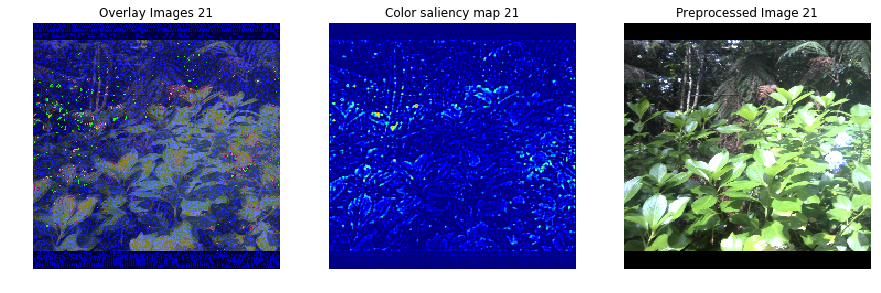

In [15]:
saliency_overlay(i=21)

predicted probability: 0.515593


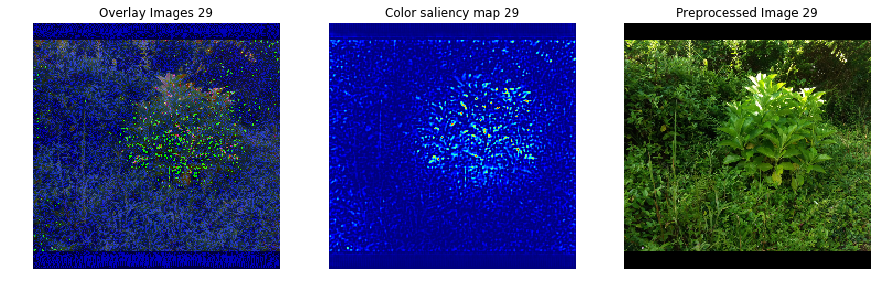

In [16]:
saliency_overlay(i=29)

Example detecting true positive: **Hydrangea flowers**

predicted probability: 1.000000


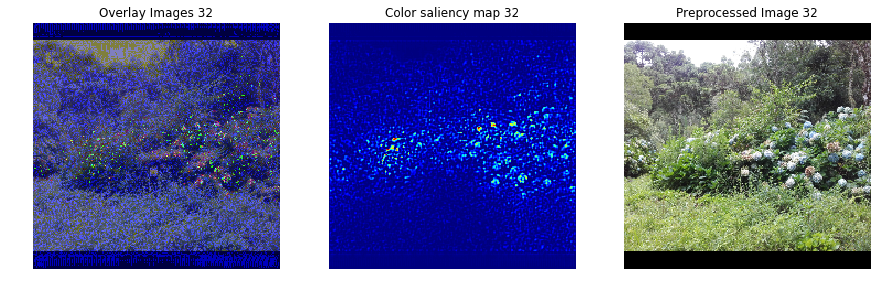

In [18]:
saliency_overlay(i=32)

Below is a false negative example. The Hydrangea flowers, although quite far away, could be obviously been observed by human eyes. However, this image has been faultly classified as noninvasive, and the saliency map shows no excitation.

predicted probability: 0.407864


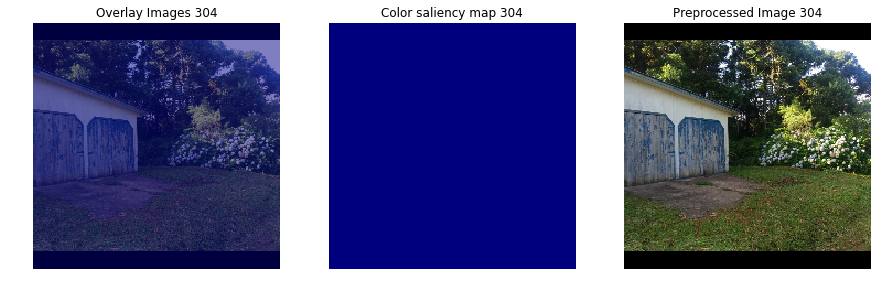

In [17]:
saliency_overlay(i=304)

The one is a very hard example (by human observation) of true positive. The **Hydrangea** also falls in the background of other irrelevant plants. On the other hand, although the image has been classified correctly, it's hard to say the excitation in the saliency map gives the correct detection of the target.

predicted probability: 0.847720


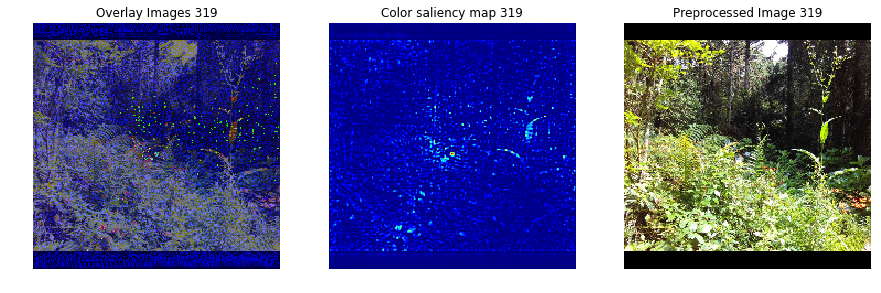

In [23]:
saliency_overlay(i=319)

Various examples of false positives

predicted probability: 0.999946


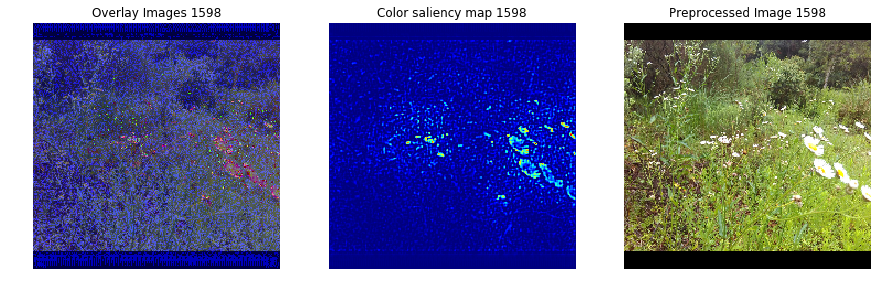

In [24]:
saliency_overlay(i=1598)

predicted probability: 0.905358


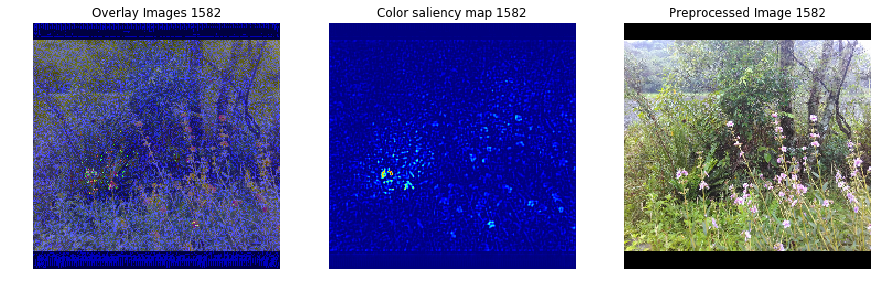

In [25]:
saliency_overlay(i=1582)

predicted probability: 0.977202


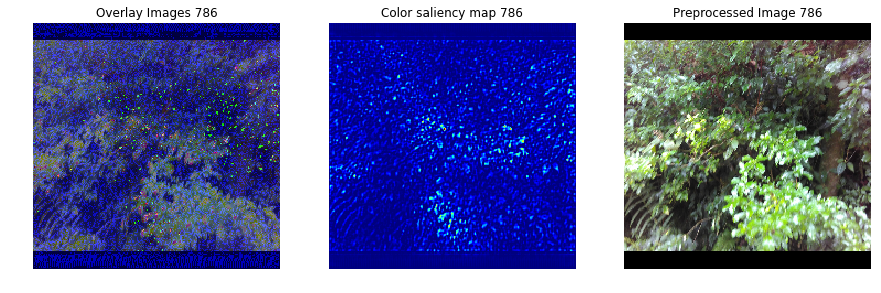

In [28]:
saliency_overlay(i=786)

For play around

predicted probability: 0.257790


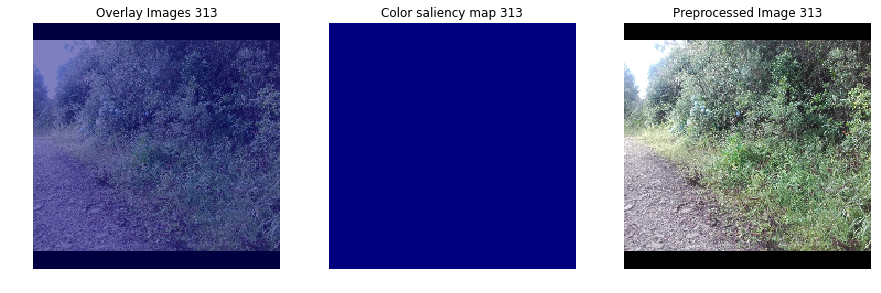

In [13]:
saliency_overlay(i=313)

## Predict on validation images and ROC curve

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2017)

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_val', X_val.shape)
print('y_val', y_val.shape)

X_train (1836, 224, 224, 3)
y_train (1836,)
X_val (459, 224, 224, 3)
y_val (459,)


In [9]:
if not model:
    model = load_model('VGG16-transferlearning.model')

In [10]:
y_val_pred = model.predict(X_val)

### Prediction accuracy

In [11]:
y_val_pred_cls = (y_val_pred > 0.5).astype('int')
acc = np.sum(y_val == y_val_pred_cls.reshape(-1)) / y_val.shape[0]
print('Val accuracy: {:.6f}'.format(acc))

Val accuracy: 0.984749


### ROC Curve

In [12]:
from sklearn.metrics import roc_curve, auc
def roc_plot(y_test, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.6f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

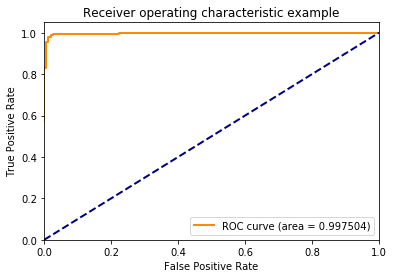

In [13]:
roc_plot(y_val, y_val_pred.reshape(-1))

## Conclusion

- The pretrained model performed extremely well at classifying invasive species.
- On the other hand, at for some cases as listed above, it looks like the model may be fooled by other flower species, or leaves that has similar shape and brightness compared with invasive species.